In [18]:
import os
from base64 import b64encode
import pickle
import numpy as np
import torch
import torch.nn as nn
from easydict import EasyDict
from IPython.display import HTML
from rich.progress import track
from sklearn.datasets import make_swiss_roll
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
matplotlib.use("Agg")

from grl.generative_models.diffusion_model import DiffusionModel
from grl.generative_models.conditional_flow_model import IndependentConditionalFlowModel, OptimalTransportConditionalFlowModel
from grl.generative_models.metric import compute_likelihood
from grl.utils import set_seed
from grl.utils.log import log

In [ ]:
from sklearn.utils import shuffle as util_shuffle


In [19]:
%matplotlib inline


def plot2d(data):
    plt.scatter(data[:, 0], data[:, 1])
    plt.show()


def show_video(video_path, video_width=600):

    video_file = open(video_path, "r+b").read()

    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(
        f"""<video width={video_width} controls><source src="{video_url}"></video>"""
    )


def render_video(
    data_list, video_save_path, iteration, fps=100, dpi=100
):
    if not os.path.exists(video_save_path):
        os.makedirs(video_save_path)
    fig = plt.figure(figsize=(6, 6))
    plt.xlim([-5, 5])
    plt.ylim([-5, 5])
    ims = []
    colors = np.linspace(0, 1, len(data_list))

    for i, data in enumerate(data_list):
        im = plt.scatter(data[:, 0], data[:, 1], s=1)
        title = plt.text(0.5, 1.05, f't={i/len(data_list):.2f}', ha='center', va='bottom', transform=plt.gca().transAxes)
        ims.append([im, title])

    ani = animation.ArtistAnimation(fig, ims, interval=0.1, blit=True)
    ani.save(os.path.join(video_save_path, f'iteration_{iteration}.mp4'), fps=fps, dpi=dpi)
    # clean up
    plt.close(fig)
    plt.clf()

def load_and_plot_results(file_path):
    try:
        with open(file_path, "rb") as f:
            results = pickle.load(f)
    except Exception as e:
        print(f"Failed to load the file: {e}")
        return

    plt.figure(figsize=(10, 6))
    x = results["iterations"]
    if "gradients" in results and results["gradients"]:
        plt.plot(x, results["gradients"], label="Gradients")
    if "losses" in results and results["losses"]:
        plt.plot(x, results["losses"], label="Losses")
    plt.xlabel("Iteration")
    plt.ylabel("Log(Value)")
    plt.yscale("log")
    # Specify y-ticks
    y_ticks = [1e-1, 5e-1, 1, 5, 10]
    plt.yticks(y_ticks, [f"{y:.0e}" for y in y_ticks])
    plt.title("Training Metrics Over Iterations")
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
x_size = 2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
t_embedding_dim = 32

diffusion_model_config = EasyDict(
    dict(
        device=device,
        project="linear_vp_sde_noise_function_score_matching",
        diffusion_model=dict(
            device=device,
            x_size=x_size,
            alpha=1.0,
            solver=dict(
                type="ODESolver",
                args=dict(
                    library="torchdiffeq_adjoint",
                ),
            ),
            path=dict(
                type="linear_vp_sde",
                beta_0=0.1,
                beta_1=20.0,
            ),
            model=dict(
                type="noise_function",
                args=dict(
                    t_encoder=dict(
                        type="GaussianFourierProjectionTimeEncoder",
                        args=dict(
                            embed_dim=t_embedding_dim,
                            scale=30.0,
                        ),
                    ),
                    backbone=dict(
                        type="TemporalSpatialResidualNet",
                        args=dict(
                            hidden_sizes=[128, 64, 32],
                            output_dim=x_size,
                            t_dim=t_embedding_dim,
                        ),
                    ),
                ),
            ),
        ),
        parameter=dict(
            training_loss_type="score_matching",
            lr=5e-4,
            data_num=100000,
            # weight_decay=1e-4,
            iterations=100000,
            batch_size=4096,
            # clip_grad_norm=1.0,
            eval_freq=1000,
            video_save_path="./video-diffusion",
            device=device,
        ),
    )
)

flow_model_config = EasyDict(
    dict(
        device=device,
        project="icfm_velocity_function_flow_matching",
        flow_model=dict(
            device=device,
            x_size=x_size,
            alpha=1.0,
            solver=dict(
                type="ODESolver",
                args=dict(
                    library="torchdiffeq_adjoint",
                ),
            ),
            path=dict(
                sigma=0.1,
            ),
            model=dict(
                type="velocity_function",
                args=dict(
                    t_encoder=dict(
                        type="GaussianFourierProjectionTimeEncoder",
                        args=dict(
                            embed_dim=t_embedding_dim,
                            scale=30.0,
                        ),
                    ),
                    backbone=dict(
                        type="TemporalSpatialResidualNet",
                        args=dict(
                            hidden_sizes=[128, 64, 32],
                            output_dim=x_size,
                            t_dim=t_embedding_dim,
                        ),
                    ),
                ),
            ),
        ),
        parameter=dict(
            training_loss_type="flow_matching",
            lr=5e-4,
            data_num=100000,
            # weight_decay=1e-4,
            iterations=100000,
            batch_size=4096,
            # clip_grad_norm=1.0,
            eval_freq=1000,
            video_save_path="./video-flow",
            device=device,
        ),
    )
)



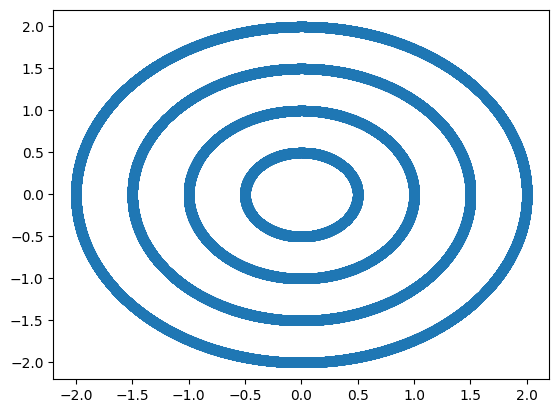

In [44]:
# from sklearn.utils import shuffle as util_shuffle
np.random.seed(192)
def make_circles(batch_size: int=1000, rng=None) -> np.ndarray:
    n_samples4 = n_samples3 = n_samples2 = batch_size // 4
    n_samples1 = batch_size - n_samples4 - n_samples3 - n_samples2

    # so as not to have the first point = last point, we set endpoint=False
    linspace4 = np.linspace(0, 2 * np.pi, n_samples4, endpoint=False)
    linspace3 = np.linspace(0, 2 * np.pi, n_samples3, endpoint=False)
    linspace2 = np.linspace(0, 2 * np.pi, n_samples2, endpoint=False)
    linspace1 = np.linspace(0, 2 * np.pi, n_samples1, endpoint=False)

    circ4_x = np.cos(linspace4)
    circ4_y = np.sin(linspace4)
    circ3_x = np.cos(linspace4) * 0.75
    circ3_y = np.sin(linspace3) * 0.75
    circ2_x = np.cos(linspace2) * 0.5
    circ2_y = np.sin(linspace2) * 0.5
    circ1_x = np.cos(linspace1) * 0.25
    circ1_y = np.sin(linspace1) * 0.25

    X = np.vstack([
        np.hstack([circ4_x, circ3_x, circ2_x, circ1_x]),
        np.hstack([circ4_y, circ3_y, circ2_y, circ1_y])
    ]).T * 3.0
    # X = util_shuffle(X, random_state=rng)

    # Add noise
    # X = X + rng.normal(scale=0.08, size=X.shape)

    return X.astype("float32")


def transform(data: np.ndarray) -> np.ndarray:
    assert data.shape[1] == 2
    data[:, 0] = data[:, 0] / np.max(np.abs(data[:, 0]))
    data[:, 1] = data[:, 1] / np.max(np.abs(data[:, 1]))
    # data[:, 2] = data[:, 2] / np.max(np.abs(data[:, 2]))
    data = (data - data.min()) / (data.max()
                                  - data.min()) # Towards [0, 1]
    data = data * 4 - 2 # [-1, 1]
    return data
# get data from sklearn
data = make_circles(100000)
data = transform(data)
data = data.astype(np.float32)
plot2d(data)
def get_train_data(dataloader):
    while True:
        yield from dataloader

In [22]:
def task_run_flow_model(config, data, flow_model_type=IndependentConditionalFlowModel):
    seed_value = set_seed()

    flow_model = flow_model_type(config=config.flow_model).to(config.flow_model.device)
    flow_model = torch.compile(flow_model)

    data_loader = torch.utils.data.DataLoader(data, batch_size=config.parameter.batch_size, shuffle=True)
    data_generator = get_train_data(data_loader)

    optimizer = torch.optim.Adam(
        flow_model.parameters(),
        lr=config.parameter.lr,
        # weight_decay=config.parameter.weight_decay,
    )
    for iteration in track(range(config.parameter.iterations), description=config.project):

        batch_data = next(data_generator).to(config.device)
        flow_model.train()
        if config.parameter.training_loss_type == "flow_matching":
            x0 = flow_model.gaussian_generator(batch_data.shape[0]).to(config.device)
            loss = flow_model.flow_matching_loss(x0=x0, x1=batch_data)
        else:
            raise NotImplementedError(
                f"Unknown loss type {config.parameter.training_loss_type}, we need flow matching."
            )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return flow_model

def task_run_diffusion_model(config, data):
    seed_value = set_seed()

    diffusion_model = DiffusionModel(config=config.diffusion_model).to(config.diffusion_model.device)
    diffusion_model = torch.compile(diffusion_model)

    data_loader = torch.utils.data.DataLoader(data, batch_size=config.parameter.batch_size, shuffle=True)
    data_generator = get_train_data(data_loader)

    optimizer = torch.optim.Adam(
        diffusion_model.parameters(),
        lr=config.parameter.lr,
        # weight_decay=config.parameter.weight_decay,
    )
    for iteration in track(range(config.parameter.iterations), description=config.project):

        batch_data = next(data_generator).to(config.device)
        diffusion_model.train()
        if config.parameter.training_loss_type == "flow_matching":
            loss = diffusion_model.flow_matching_loss(batch_data)
        elif config.parameter.training_loss_type == "score_matching_maximum_likelihhood":
            loss = diffusion_model.score_matching_loss(batch_data)
        elif config.parameter.training_loss_type == "score_matching":
            loss = diffusion_model.score_matching_loss(batch_data, weighting_scheme="vanilla")
        else:
            raise NotImplementedError(
                f"Unknown loss type {config.parameter.training_loss_type}, we need flow matching or score matching."
            )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return diffusion_model

In [23]:
diffusion_model = task_run_diffusion_model(diffusion_model_config, data)
flow_model = task_run_flow_model(flow_model_config, data, IndependentConditionalFlowModel)

Output()

Output()

In [24]:
t_span = torch.linspace(0.0, 1.0, 1000)
# diffusion model

x = diffusion_model.sample(t_span=t_span, batch_size=1)
print(f"diffusion_model: shape of x: {x.shape}")
with torch.no_grad():
    logp = compute_likelihood(diffusion_model, x)
    print(f"diffusion_model: likelihood: {torch.exp(logp)}")

# flow model
x = flow_model.sample(t_span=t_span, batch_size=1)
print(f"flow_model: shape of x: {x.shape}")
with torch.no_grad():
    logp = compute_likelihood(flow_model, x)
    print(f"flow_model: likelihood: {torch.exp(logp)}")

diffusion_model: shape of x: torch.Size([1, 2])
diffusion_model: likelihood: tensor([0.1089], device='cuda:0')
flow_model: shape of x: torch.Size([1, 2])
flow_model: likelihood: tensor([0.0774], device='cuda:0')


In [25]:
# diffusion model

x = diffusion_model.sample(t_span=t_span, batch_size=1)
print(f"diffusion_model: shape of x: {x.shape}")
logp = compute_likelihood(diffusion_model, x)
print(f"diffusion_model: likelihood: {torch.exp(logp)}")

# test if the tensor has grad_fn
assert logp.grad_fn is not None

# flow model

x = flow_model.sample(t_span=t_span, batch_size=1)
print(f"flow_model: shape of x: {x.shape}")
logp = compute_likelihood(flow_model, x)
print(f"flow_model: likelihood: {torch.exp(logp)}")

# test if the tensor has grad_fn
assert logp.grad_fn is not None

diffusion_model: shape of x: torch.Size([1, 2])
diffusion_model: likelihood: tensor([0.1333], device='cuda:0', grad_fn=<ExpBackward0>)
flow_model: shape of x: torch.Size([1, 2])
flow_model: likelihood: tensor([0.1217], device='cuda:0', grad_fn=<ExpBackward0>)


In [26]:
# diffusion model

x = diffusion_model.sample(t_span=t_span, batch_size=1)
print(f"diffusion_model: shape of x: {x.shape}")
logp = compute_likelihood(diffusion_model, x, using_Hutchinson_trace_estimator=True)
print(f"diffusion_model: likelihood: {torch.exp(logp)}")

# test if the tensor has grad_fn
assert logp.grad_fn is not None

# flow model

x = flow_model.sample(t_span=t_span, batch_size=1)
print(f"flow_model: shape of x: {x.shape}")
logp = compute_likelihood(diffusion_model, x, using_Hutchinson_trace_estimator=True)
print(f"flow_model: likelihood: {torch.exp(logp)}")

# test if the tensor has grad_fn
assert logp.grad_fn is not None


diffusion_model: shape of x: torch.Size([1, 2])
diffusion_model: likelihood: tensor([0.1349], device='cuda:0', grad_fn=<ExpBackward0>)
flow_model: shape of x: torch.Size([1, 2])
flow_model: likelihood: tensor([0.0012], device='cuda:0', grad_fn=<ExpBackward0>)


In [27]:
def density_flow_of_generative_model(model):

    model.eval()
    x_range = torch.linspace(-4, 4, 100, device=model.device)
    y_range = torch.linspace(-4, 4, 100, device=model.device)
    xx, yy = torch.meshgrid(x_range, y_range)
    z_grid = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], 1)

    indexs = torch.arange(0, z_grid.shape[0], device=model.device)
    memory = 0.01

    p_list = []
    for t in track(range(100), description="Density Flow Training"):
        t_span = torch.linspace(0.01 * t, 1, 101 - t, device=model.device)
        logp_list = []
        for ii in torch.split(indexs, int(z_grid.shape[0] * memory)):
            logp_ii = compute_likelihood(
                model=model,
                x=z_grid[ii],
                t=t_span,
                using_Hutchinson_trace_estimator=True,
            )
            logp_list.append(logp_ii.unsqueeze(0))
        logp = torch.cat(logp_list, 1)
        p = torch.exp(logp).reshape(100, 100)
        p_list.append(p)

    return p_list
p_list = density_flow_of_generative_model(diffusion_model)

Output()

In [41]:
def render_density_flow_video(p_list, video_save_path, fps=20, dpi=100, generate_path=True):
    if not os.path.exists(video_save_path):
        os.makedirs(video_save_path)

    fig, ax = plt.subplots(figsize=(7, 6))
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

    ims = []
    colors = np.linspace(0, 1, len(p_list))

    # Assuming p_list contains 2D arrays of the same shape
    x = np.linspace(-4, 4, p_list[0].shape[1])
    y = np.linspace(-4, 4, p_list[0].shape[0])
    X, Y = np.meshgrid(x, y)

    cbar = None  # Initialize color bar

    if generate_path:
        enumerate_items = list(enumerate(p_list))[::-1]
        enumerate_items = enumerate_items[:-1]
        # enumerate_items = enumerate_items
    else:
        enumerate_items = list(enumerate(p_list))[1:]

    for i, p in enumerate_items:
        p_max = 0.2
        p_min = 0.0

        im = ax.pcolormesh(
            Y, X, p.cpu().detach().numpy(),
            cmap="viridis",
            vmin=p_min, vmax=p_max,
            shading='auto'
        )
        title = ax.text(0.5, 1.05, f't={colors[i]:.2f}', size=plt.rcParams["axes.titlesize"], ha="center", transform=ax.transAxes)

        # Remove the previous color bar if it exists
        if cbar:
            cbar.remove()

        # Adding the colorbar inside the loop to update it each frame
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Density')

        ims.append([im, title])

    ani = animation.ArtistAnimation(fig, ims, interval=20/fps, blit=True)
    ani.save(
        os.path.join(video_save_path, f"density_flow_diffuse.mp4"),
        fps=fps,
        dpi=dpi,
    )

    # clean up
    plt.close(fig)
    plt.clf()
render_density_flow_video(p_list=p_list, video_save_path=diffusion_model_config.parameter.video_save_path, generate_path=False)

[11:34:18] INFO     Animation.save using <class 'matplotlib.animation.FFMpegWriter'>              ]8;id=198352;file:///opt/conda/lib/python3.10/site-packages/matplotlib/animation.py\animation.py]8;;\:]8;id=80104;file:///opt/conda/lib/python3.10/site-packages/matplotlib/animation.py#1060\1060]8;;\

           INFO     MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s      ]8;id=561233;file:///opt/conda/lib/python3.10/site-packages/matplotlib/animation.py\animation.py]8;;\:]8;id=842454;file:///opt/conda/lib/python3.10/site-packages/matplotlib/animation.py#338\338]8;;\
                    700x600 -pix_fmt rgba -framerate 20 -loglevel error -i pipe: -vcodec h264                      
                    -pix_fmt yuv420p -y ./video-diffusion/density_flow_diffuse.mp4                                 

<Figure size 640x480 with 0 Axes>